# Introduction/ Business Problem

In this project we will try to find Best Quality Restaurants for differnt cuisines. My targert audience is tourists and locals who wanted to find good quality food based on user recommendations.

# Data Description

NewYork DataSet:
New York has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

Luckily, this dataset exists for free on the web. Here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572


# Methodoloy

I will take the gathered data, and will create a k-means clustering algorithm that groups restaurants into 4-5 clusters so that people looking to eat in New York can easily see which restaurants are the best to eat at and what cuisine is available.

### Importing Libraries

In [15]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import beautiful soup
#from urllib.request import urlopen
#from bs4 import BeautifulSoup


print('Libraries imported.')

Libraries imported.


### Finding the geo data for New York

In [52]:
address = 'New York, New York'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The geograpical coordinate of New York are 40.7127281, -74.0060152.


In [53]:
CLIENT_ID = '0VBWUB4MAQ3HZOS1MMHWKEKLL2IOD4NADSMR1H035CPKI2R1' # your Foursquare ID
CLIENT_SECRET = 'NXKSW5DAK0ETHNKABWVB1YVTBEPGZ23KANPD4XF0OIGR52IX' # your Foursquare Secret
VERSION = '20191201'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0VBWUB4MAQ3HZOS1MMHWKEKLL2IOD4NADSMR1H035CPKI2R1
CLIENT_SECRET:NXKSW5DAK0ETHNKABWVB1YVTBEPGZ23KANPD4XF0OIGR52IX


Creating a URL for all of the venues in New York

In [54]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=0VBWUB4MAQ3HZOS1MMHWKEKLL2IOD4NADSMR1H035CPKI2R1&client_secret=NXKSW5DAK0ETHNKABWVB1YVTBEPGZ23KANPD4XF0OIGR52IX&v=20191201&ll=40.7127281,-74.0060152&radius=500&limit=100'

Pulling the JSON for the URL of venues.

In [55]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e04d8fbfb34b5001be572b3'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Downtown Manhattan',
  'headerFullLocation': 'Downtown Manhattan, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 168,
  'suggestedBounds': {'ne': {'lat': 40.7172281045, 'lng': -74.00008952063419},
   'sw': {'lat': 40.7082280955, 'lng': -74.0119408793658}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '57f0689d498e7d49d9189369',
       'name': 'The Bar Room at Temple Court',
       'location': {'address': '123 Nassau St',
        'lat': 40.7114477287544,
        'lng': -74.00680157032005,
        'labe

Now we start pulling the data from Foursquare into a dataframe so we can manipulate and use it.

In [56]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [57]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802
1,The Beekman - A Thompson Hotel,56d8c0f8498edb854f926e6a,Hotel,40.711173,-74.006702
2,Alba Dry Cleaner & Tailor,4c606c3e1e5cd13ad1a1a1ed,Laundry Service,40.711434,-74.006272
3,City Hall Park,3fd66200f964a520d8f11ee3,Park,40.712415,-74.006724
4,Gibney Dance Center Downtown,53373f26498e940581c90985,Dance Studio,40.713923,-74.005661
5,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660
6,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395
7,The Class by Taryn Toomey,58a253c830ecc66c9e5b40a0,Gym / Fitness Center,40.712753,-74.008734
8,CrossFit 212 TriBeCa,52001eed498e9ac16ca5e20b,Gym,40.714537,-74.005999
9,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804


In [58]:
#fix the column names so they look relatively normal

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,id,categories,lat,lng
0,The Bar Room at Temple Court,57f0689d498e7d49d9189369,Hotel Bar,40.711448,-74.006802
1,The Beekman - A Thompson Hotel,56d8c0f8498edb854f926e6a,Hotel,40.711173,-74.006702
2,Alba Dry Cleaner & Tailor,4c606c3e1e5cd13ad1a1a1ed,Laundry Service,40.711434,-74.006272
3,City Hall Park,3fd66200f964a520d8f11ee3,Park,40.712415,-74.006724
4,Gibney Dance Center Downtown,53373f26498e940581c90985,Dance Studio,40.713923,-74.005661
5,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660
6,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395
7,The Class by Taryn Toomey,58a253c830ecc66c9e5b40a0,Gym / Fitness Center,40.712753,-74.008734
8,CrossFit 212 TriBeCa,52001eed498e9ac16ca5e20b,Gym,40.714537,-74.005999
9,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804


In [59]:
# find a list of unique categories from the API so we can see what may or may not fit for restaurants

Uniq_Res_Names = nearby_venues['categories'].unique()

In [60]:
Uniq_Res_Names

array(['Hotel Bar', 'Hotel', 'Laundry Service', 'Park', 'Dance Studio',
       'French Restaurant', 'Coffee Shop', 'Gym / Fitness Center', 'Gym',
       'Bakery', 'Indian Restaurant', 'Falafel Restaurant',
       'Sandwich Place', 'Monument / Landmark', 'Building',
       'American Restaurant', 'Taco Place', 'Yoga Studio', 'Pizza Place',
       'Boxing Gym', 'Cuban Restaurant', 'Italian Restaurant',
       'Sporting Goods Shop', 'Café', 'Plaza', 'Burger Joint', 'Bar',
       'Event Space', 'Furniture / Home Store', 'Burrito Place',
       'Liquor Store', 'Restaurant', 'Spa', 'Antique Shop',
       'Middle Eastern Restaurant', 'Fast Food Restaurant',
       'Martial Arts Dojo', 'Strip Club', 'Coworking Space', 'Baby Store',
       'Bookstore', 'Japanese Restaurant', "Women's Store", 'Juice Bar',
       'Discount Store', 'Speakeasy', 'Cocktail Bar', 'Nail Salon',
       'Molecular Gastronomy Restaurant', 'Wine Shop', 'Art Gallery',
       'Sushi Restaurant', 'Greek Restaurant', 'Comic Sh

In [61]:
FoodNames= ['French Restaurant', 'Coffee Shop','Bakery', 'Indian Restaurant', 'Sandwich Place','Falafel Restaurant','American Restaurant','Taco Place', 'Pizza Place','Cuban Restaurant', 'Italian Restaurant','Café', 'Burger Joint', 'Bar','Restaurant', 'Burrito Place','Middle Eastern Restaurant', 'Fast Food Restaurant','Japanese Restaurant','Juice Bar','Cocktail Bar','Molecular Gastronomy Restaurant', 'Sushi Restaurant','Greek Restaurant','Japanese Curry Restaurant', 'Bubble Tea Shop','Deli / Bodega', 'Vegetarian / Vegan Restaurant', 'Salad Place']

In [62]:
nearby_FRest= nearby_venues[nearby_venues.categories.isin(FoodNames)]
nearby_FRest

,name,id,categories,lat,lng
5,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660
6,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395
9,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804
10,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994
11,The Hummus & Pita Co,515c4ca3e4b00279706b095d,Falafel Restaurant,40.714453,-74.006853
12,Pisillo Italian Panini,528bf16711d2b7722da6b51c,Sandwich Place,40.710530,-74.007526
16,Temple Court,57dc7ea2498e2a830309c81c,American Restaurant,40.711491,-74.006832
17,Los Tacos No. 1,5d5f24ec09484500079aee00,Taco Place,40.714267,-74.008756
19,Racines,534c9d7b498e1bdd443a40e1,French Restaurant,40.714754,-74.007581
20,Birch Coffee,56e7f585498ed6598b4030cd,Coffee Shop,40.710759,-74.005953


In [63]:
nearby_FRest= nearby_FRest.reset_index(drop=True)
nearby_FRest

,name,id,categories,lat,lng
0,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660
1,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395
2,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804
3,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994
4,The Hummus & Pita Co,515c4ca3e4b00279706b095d,Falafel Restaurant,40.714453,-74.006853
5,Pisillo Italian Panini,528bf16711d2b7722da6b51c,Sandwich Place,40.710530,-74.007526
6,Temple Court,57dc7ea2498e2a830309c81c,American Restaurant,40.711491,-74.006832
7,Los Tacos No. 1,5d5f24ec09484500079aee00,Taco Place,40.714267,-74.008756
8,Racines,534c9d7b498e1bdd443a40e1,French Restaurant,40.714754,-74.007581
9,Birch Coffee,56e7f585498ed6598b4030cd,Coffee Shop,40.710759,-74.005953


Now let's get a list of venue ids so we can pull likes and add to our dataframe.

In [64]:
#let's get a list of venues

venue_id_list = nearby_FRest['id'].tolist()

In [65]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[227, 150, 661, 52, 87, 286, 120, 39, 113, 171, 58, 52, 112, 72, 99, 11, 294, 498, 165, 403, 126, 68, 24, 66, 50, 51, 265, 90, 176, 130, 21, 468, 34, 162, 18, 178, 558, 311, 446, 303, 280, 185, 173, 83, 7, 67, 97, 36, 85, 4, 12]


In [66]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

51
51


# Data Prep Intro
The thought process behind this is that likes are a proxy for quality. The more likes there are, the better the restaurant is. This might be incorrect but API call issues (how many I can use for free) holds me back from getting price / rating data. I will then bin this data into a quality categorical variables so we can cluster appropriately.

I am also going to create new categorical variables for the restaurants to better group them based on type of cuisine. This way you can look for good mexican food or now what type of food might be best to eat in New York if you are new to the area.

Now let's start prepping our data for clustering. This will include combining data from different lists, creating new categorical data to be used, binning data and then encoding the data for clustering.

In [67]:
#let's make a copy of our initial dataframe just in case anything goes wrong

NY_venues = nearby_FRest.copy()
NY_venues.head()

,name,id,categories,lat,lng
0,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660
1,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395
2,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804
3,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994
4,The Hummus & Pita Co,515c4ca3e4b00279706b095d,Falafel Restaurant,40.714453,-74.006853


In [68]:
# add in the list of likes

NY_venues['total likes'] = like_list
NY_venues.head()

,name,id,categories,lat,lng,total likes
0,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660,227
1,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395,150
2,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804,661
3,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994,52
4,The Hummus & Pita Co,515c4ca3e4b00279706b095d,Falafel Restaurant,40.714453,-74.006853,87


In [69]:
#Let's look at our like data to set bins

# now let's bin total likes

print(NY_venues['total likes'].max())
print(NY_venues['total likes'].min())
print(NY_venues['total likes'].median())
print(NY_venues['total likes'].mean())

661
4
112.0
161.64705882352942


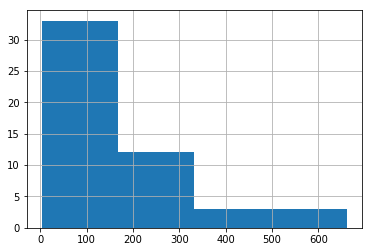

In [70]:
# let's visualize our total likes based on a histogram

import matplotlib.pyplot as plt
%matplotlib inline
NY_venues['total likes'].hist(bins=4)
plt.show()

In [71]:
# what are the bins we want to use?

print(np.percentile(NY_venues['total likes'], 25))
print(np.percentile(NY_venues['total likes'], 50))
print(np.percentile(NY_venues['total likes'], 75))

52.0
112.0
206.0


In [72]:
# now we have our bin values so let's set them to the appropriate values
# less than 52, 52-112, 112-206, 206>
# poor, below avg, abv avg, great

poor = NY_venues['total likes']<=52
below_avg = NY_venues[(NY_venues['total likes']>52) & (NY_venues['total likes']<=112)]
abv_avg = NY_venues[(NY_venues['total likes']>112) & (NY_venues['total likes']<=206)]
great = NY_venues['total likes']>206

In [73]:
# let's set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=24:
        return 'poor'
    if s['total likes']<=45:
        return 'below avg'
    if s['total likes']<=76:
        return 'avg avg'
    if s['total likes']>76:
        return 'great'

NY_venues['total likes_cat']=NY_venues.apply(conditions, axis=1)

In [74]:
NY_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat
0,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660,227,great
1,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395,150,great
2,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804,661,great
3,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994,52,avg avg
4,The Hummus & Pita Co,515c4ca3e4b00279706b095d,Falafel Restaurant,40.714453,-74.006853,87,great


In [75]:
# let's star the process for re-categorizing the categories

NY_venues['categories'].unique()

array(['French Restaurant', 'Coffee Shop', 'Bakery', 'Indian Restaurant',
       'Falafel Restaurant', 'Sandwich Place', 'American Restaurant',
       'Taco Place', 'Pizza Place', 'Cuban Restaurant',
       'Italian Restaurant', 'Café', 'Burger Joint', 'Bar',
       'Burrito Place', 'Restaurant', 'Middle Eastern Restaurant',
       'Fast Food Restaurant', 'Japanese Restaurant', 'Juice Bar',
       'Cocktail Bar', 'Molecular Gastronomy Restaurant',
       'Sushi Restaurant', 'Greek Restaurant',
       'Japanese Curry Restaurant', 'Bubble Tea Shop', 'Deli / Bodega',
       'Vegetarian / Vegan Restaurant', 'Salad Place'], dtype=object)

In [76]:
# let's create our new categories and create a function to apply those to our existing data

European_food= ['French Restaurant','Pizza Place','Italian Restaurant']
South_American_food= ['Taco Place','Cuban Restaurant', 'Burrito Place','Deli / Bodega']
South_East_Asian_food=['Indian Restaurant','Vegetarian / Vegan Restaurant']
Middle_East_food=['Falafel Restaurant','Middle Eastern Restaurant','Greek Restaurant']
East_Asian_food=['Japanese Restaurant','Sushi Restaurant','Japanese Curry Restaurant']
American_food=['American Restaurant','Burger Joint','Restaurant','Fast Food Restaurant']
Other=['Coffee Shop','Bakery','Sandwich Place','Café','Juice Bar','Cocktail Bar','Molecular Gastronomy Restaurant','Bubble Tea Shop','Salad Place']
bars=['Bar']


def conditions2(s):
    if s['categories'] in bars:
        return 'Bars'
    if s['categories'] in Other:
        return 'Other'
    if s['categories'] in American_food:
        return 'American food'
    if s['categories'] in East_Asian_food:
        return 'East Asian food'
    if s['categories'] in Middle_East_food:
        return 'Middle East food'
    if s['categories'] in South_East_Asian_food:
        return 'South East Asian food'
    if s['categories'] in South_American_food:
        return 'South American food'
    if s['categories'] in European_food:
        return 'European food'

NY_venues['categories_new']=NY_venues.apply(conditions2, axis=1)

In [77]:
NY_venues

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new
0,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660,227,great,European food
1,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395,150,great,Other
2,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804,661,great,Other
3,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994,52,avg avg,South East Asian food
4,The Hummus & Pita Co,515c4ca3e4b00279706b095d,Falafel Restaurant,40.714453,-74.006853,87,great,Middle East food
5,Pisillo Italian Panini,528bf16711d2b7722da6b51c,Sandwich Place,40.710530,-74.007526,286,great,Other
6,Temple Court,57dc7ea2498e2a830309c81c,American Restaurant,40.711491,-74.006832,120,great,American food
7,Los Tacos No. 1,5d5f24ec09484500079aee00,Taco Place,40.714267,-74.008756,39,below avg,South American food
8,Racines,534c9d7b498e1bdd443a40e1,French Restaurant,40.714754,-74.007581,113,great,European food
9,Birch Coffee,56e7f585498ed6598b4030cd,Coffee Shop,40.710759,-74.005953,171,great,Other


In [78]:
# one hot encoding
NY_onehot = pd.get_dummies(NY_venues[['categories', 'total likes_cat']], prefix="", prefix_sep="")

# add Restaurant name back to dataframe
NY_onehot['Name'] = NY_venues['name'] 

# move Restaurant name column to the first column
fixed_columns = [NY_onehot.columns[-1]] + list(NY_onehot.columns[:-1])
NY_onehot = NY_onehot[fixed_columns]

NY_onehot.head()

,Name,American Restaurant,Bakery,Bar,Bubble Tea Shop,Burger Joint,Burrito Place,Café,Cocktail Bar,Coffee Shop,Cuban Restaurant,Deli / Bodega,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Juice Bar,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Pizza Place,Restaurant,Salad Place,Sandwich Place,Sushi Restaurant,Taco Place,Vegetarian / Vegan Restaurant,avg avg,below avg,great,poor
0,Augustine,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,The Wooly Daily,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Takahachi Bakery,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Aahar Indian Cuisine,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,The Hummus & Pita Co,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# Clustering

In [79]:
cluster_df = NY_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 2, 1, 1, 1, 0, 1, 1], dtype=int32)

In [85]:
kmeans.labels_

array([1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1, 3, 1, 1, 1, 1, 1, 2,
       3, 2, 2, 2, 1, 1, 1, 1, 3, 1, 0, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 2, 1, 0, 1, 3, 3], dtype=int32)

In [80]:
#Let's add our cluster labels back into our original dataframe.

NY_venues['label'] = kmeans.labels_
NY_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660,227,great,European food,1
1,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395,150,great,Other,1
2,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804,661,great,Other,1
3,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994,52,avg avg,South East Asian food,2
4,The Hummus & Pita Co,515c4ca3e4b00279706b095d,Falafel Restaurant,40.714453,-74.006853,87,great,Middle East food,1


In [81]:
# Now let's visualize what our clusters look like for New York.

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY_venues['lat'], NY_venues['lng'], NY_venues['name'], NY_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now let's see what is in each of our clusters

### Cluster1

In [82]:
NY_venues.loc[NY_venues['label']==0]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
7,Los Tacos No. 1,5d5f24ec09484500079aee00,Taco Place,40.714267,-74.008756,39,below avg,South American food,0
32,Primo’s,5ae28a7b15173e002cef3271,Cocktail Bar,40.715501,-74.008977,34,below avg,Other,0
47,Lenwich,5123cc09e4b05424264ac373,Deli / Bodega,40.713301,-74.009116,36,below avg,South American food,0


### Cluster2

In [83]:
NY_venues.loc[NY_venues['label']==1]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Augustine,58191674ded8f8626ed70af0,French Restaurant,40.711310,-74.006660,227,great,European food,1
1,The Wooly Daily,56093809498e5344ab8835a6,Coffee Shop,40.712137,-74.008395,150,great,Other,1
2,Takahachi Bakery,4c154c9a77cea593c401d260,Bakery,40.713653,-74.008804,661,great,Other,1
4,The Hummus & Pita Co,515c4ca3e4b00279706b095d,Falafel Restaurant,40.714453,-74.006853,87,great,Middle East food,1
5,Pisillo Italian Panini,528bf16711d2b7722da6b51c,Sandwich Place,40.710530,-74.007526,286,great,Other,1
6,Temple Court,57dc7ea2498e2a830309c81c,American Restaurant,40.711491,-74.006832,120,great,American food,1
8,Racines,534c9d7b498e1bdd443a40e1,French Restaurant,40.714754,-74.007581,113,great,European food,1
9,Birch Coffee,56e7f585498ed6598b4030cd,Coffee Shop,40.710759,-74.005953,171,great,Other,1
12,Sophie's Cuban Cuisine,4b311e89f964a520890025e3,Cuban Restaurant,40.714803,-74.007656,112,great,South American food,1
14,Da Claudio,5447e0b2498e49ee7c7b1dc0,Italian Restaurant,40.710826,-74.007639,99,great,European food,1


### Cluster3

In [84]:
NY_venues.loc[NY_venues['label']==2]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
3,Aahar Indian Cuisine,575dea4c498e2739e43a27e2,Indian Restaurant,40.713307,-74.007994,52,avg avg,South East Asian food,2
10,Joe’s Pizza,5c6f03f30802d4002c16884c,Pizza Place,40.710318,-74.007694,58,avg avg,European food,2
11,Hank's Juicy Beef,576c8b3c498eecbf1adee8e9,Sandwich Place,40.714349,-74.007215,52,avg avg,Other,2
13,Gran Morsi,5421eb06498e1b6b9c1bfd9c,Italian Restaurant,40.714246,-74.007925,72,avg avg,European food,2
21,The Wooly Public,58ae412372714f32e282e2d7,Restaurant,40.712099,-74.008345,68,avg avg,American food,2
23,Chick-fil-A,5ab51b6aa4b51b3dc096ed68,Fast Food Restaurant,40.710419,-74.008550,66,avg avg,American food,2
24,Potbelly Sandwich Shop,4f4d2593e4b00b42c3f1060f,Sandwich Place,40.714480,-74.005842,50,avg avg,Other,2
25,Konditori,5953e5314382ab0b3b808dc6,Café,40.709474,-74.006630,51,avg avg,Other,2
45,Kesté,58f54555e2ead178a41de832,Pizza Place,40.709132,-74.004676,67,avg avg,European food,2


### Cluster4

In [86]:
NY_venues.loc[NY_venues['label']==3]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
15,Pisillo Italian Cafe,588a4316326c5a4b60559f17,Café,40.710493,-74.007546,11,poor,Other,3
22,Pita Express,4b55feaff964a520f8fa27e3,Middle Eastern Restaurant,40.711028,-74.007965,24,poor,Middle East food,3
30,Hungry Ghost,5c7d2d843d4791002c881f1c,Coffee Shop,40.715379,-74.007476,21,poor,Other,3
34,Recreation,5b95344dc58ed7002cbe8a79,Bar,40.710773,-74.007912,18,poor,Bars,3
44,Gong Cha,5bec5ea23e67417691559498,Bubble Tea Shop,40.710704,-74.009257,7,poor,Other,3
49,sweetgreen,5ceeb56dc03635002ce7ab2a,Salad Place,40.715493,-74.008951,4,poor,Other,3
50,Vivi Bubble Tea,58fd2804f79faa1c9cb04e81,Bubble Tea Shop,40.715950,-74.004583,12,poor,Other,3
